In [1]:
! pip install ohmeow-blurr -Uqq
! pip install transformers[sentencepiece] -Uqq
! pip install datasets -Uqq
! pip install bert_score -Uqq

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import pdb
import os
import nltk
nltk.download('punkt')

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, PreTrainedTokenizerBase, logging,BartForConditionalGeneration
from fastai.text.all import *
from blurr.utils import print_versions
from blurr.text.utils import BlurrText, get_hf_objects
from blurr.text.data.seq2seq.core import Seq2SeqBatchTokenizeTransform, Seq2SeqPreprocessor, Seq2SeqTextBlock, default_text_gen_kwargs
from blurr.text.modeling.core import BaseModelCallback, BaseModelWrapper, Blearner
from blurr.text.modeling.seq2seq.core import Seq2SeqMetricsCallback, blurr_seq2seq_splitter

[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
NLP = BlurrText()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.11.0a0+17540c5
fastai: 2.5.6
transformers: 4.18.0


In [6]:
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: Quadro RTX 5000


In [7]:
raw_datasets = load_dataset("cnn_dailymail", "3.0.0", split=["train", "validation"])
raw_datasets

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /home/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

[Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 287113
 }),
 Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 13368
 })]

In [8]:
print(raw_datasets[0][0].keys())
print(raw_datasets[0][0]["highlights"])

print(raw_datasets[1][0].keys())
print(raw_datasets[1][0]["highlights"])

dict_keys(['article', 'highlights', 'id'])
Syrian official: Obama climbed to the top of the tree, "doesn't know how to get down"
Obama sends a letter to the heads of the House and Senate .
Obama to seek congressional approval on military action against Syria .
Aim is to determine whether CW were used, not by whom, says U.N. spokesman .
dict_keys(['article', 'highlights', 'id'])
Accident happens in Santa Ynez, California, near where Crosby lives .
The jogger suffered multiple fractures; his injuries are not believed to be life-threatening .


In [9]:
raw_train_ds = raw_datasets[0].shuffle(seed=42).select(range(1000))
raw_valid_ds = raw_datasets[1].shuffle(seed=42).select(range(200))

len(raw_train_ds) + len(raw_valid_ds)

1200

In [10]:
raw_train_df = pd.DataFrame(raw_train_ds)
raw_valid_df = pd.DataFrame(raw_valid_ds)

raw_train_df.head(2)

,article,highlights,id
0,"A protester in Ferguson was arrested during a demonstration on Thursday night - and live-tweeted her entire experience. Brittany Ferrell, a nursing student at the University of Missouri-Saint Louis, was one of 13 people detained by officers in the conflicted Missouri city for 'noise disruption'. The detention has sparked an investigation by the American Civil Liberties Union as lawyers accuse officers of overstretching their powers. Scroll down for video . Arrested: This is Brittany Ferrell, the nursing student and protester who live-tweeted her arrest in Ferguson . Tweeting in handcuffs, ...","Brittany Ferrell, nursing student, was arrested with 12 people on Thursday .\nThey were calling on police take responsibility for Michael Brown's death .\nMs Ferrell tweeted as she was arrested, piled in a small wagon with 7 others .\nThey were accused of 'noise disruption', put in orange jumpsuits and cuffed .\nOfficers now being investigated, lawyers claim they 'overstretched powers'",1e01f238418c31d4e9093f6334e0232babeb639a
1,"A day after confirming it had lost the ability to display Instagram images, Twitter has rolled out its own library of retro filters for its Android and iPhone apps. The eight filters are the usual suspects we've come to expect from mobile photo apps, including desaturated, black and white and high contrast. There are auto-adjust and cropping options, as well as a helpful grid view that lets you see what each filter will look like at once. ""The latest versions of Twitter for iPhone and Twitter for Android introduce a few new ways to enhance the images you tweet,"" said Twitter senior designe...",Twitter has added photo filters to its Android and iOS mobile apps .\nThe addition will help Twitter compete against Facebook-owned Instagram .\nThis is the first time the social network has offered image editing tools .,6f89645bff243fe9ce2a0509e5ca01912abf0d10


In [14]:
pretrained_model_name = "sshleifer/distilbart-cnn-6-6"
model_cls = BartForConditionalGeneration

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls)

https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/.cache/huggingface/transformers/tmprry9arma


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/config.json in cache at /home/.cache/huggingface/transformers/98e51ece807bb08f235356791c26c1d775cc56c394304f0ddf1809c6bc45b391.a394a5757192281a4f3940a7ccf20051a750f630dd86fffbaa84d8cff7a0d496
creating metadata file for /home/.cache/huggingface/transformers/98e51ece807bb08f235356791c26c1d775cc56c394304f0ddf1809c6bc45b391.a394a5757192281a4f3940a7ccf20051a750f630dd86fffbaa84d8cff7a0d496
loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/98e51ece807bb08f235356791c26c1d775cc56c394304f0ddf1809c6bc45b391.a394a5757192281a4f3940a7ccf20051a750f630dd86fffbaa84d8cff7a0d496
Model config BartConfig {
  "_name_or_path": "sshleifer/distilbart-cnn-6-6",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForC

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/tokenizer_config.json in cache at /home/.cache/huggingface/transformers/41a44e7ad55ba42aa9abd4697be8ff844b95c3f33ad59ceb5059b263caf581fe.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8
creating metadata file for /home/.cache/huggingface/transformers/41a44e7ad55ba42aa9abd4697be8ff844b95c3f33ad59ceb5059b263caf581fe.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8
loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/98e51ece807bb08f235356791c26c1d775cc56c394304f0ddf1809c6bc45b391.a394a5757192281a4f3940a7ccf20051a750f630dd86fffbaa84d8cff7a0d496
Model config BartConfig {
  "_name_or_path": "sshleifer/distilbart-cnn-6-6",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
   

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/vocab.json in cache at /home/.cache/huggingface/transformers/c457182dd3c47e71636dfe957c948acf12fd6b1d17d3e16a69f9bd731f340157.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
creating metadata file for /home/.cache/huggingface/transformers/c457182dd3c47e71636dfe957c948acf12fd6b1d17d3e16a69f9bd731f340157.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /home/.cache/huggingface/transformers/tmpb1zrbry7


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/merges.txt in cache at /home/.cache/huggingface/transformers/1917cd1903f32920951797d984eff6fb9707c20aa7c0eba679d033d5d5dbc7d3.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /home/.cache/huggingface/transformers/1917cd1903f32920951797d984eff6fb9707c20aa7c0eba679d033d5d5dbc7d3.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/vocab.json from cache at /home/.cache/huggingface/transformers/c457182dd3c47e71636dfe957c948acf12fd6b1d17d3e16a69f9bd731f340157.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
loading file https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/merges.txt from cache at /home/.cache/huggingface/transformers/1917cd1903f32920951797d984eff6fb9707c20aa7c0eba679d033d5d5dbc7d3.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/pytorch_model.bin in cache at /home/.cache/huggingface/transformers/b3a80b0a1380627404ab7beeafae5a22d57a6caee6d637757be7b02319a26d37.a3aeae96c9bbfd0fad6832e6f41a23b7f17b292daca2c554b8064433b145e921
creating metadata file for /home/.cache/huggingface/transformers/b3a80b0a1380627404ab7beeafae5a22d57a6caee6d637757be7b02319a26d37.a3aeae96c9bbfd0fad6832e6f41a23b7f17b292daca2c554b8064433b145e921
loading weights file https://huggingface.co/sshleifer/distilbart-cnn-6-6/resolve/main/pytorch_model.bin from cache at /home/.cache/huggingface/transformers/b3a80b0a1380627404ab7beeafae5a22d57a6caee6d637757be7b02319a26d37.a3aeae96c9bbfd0fad6832e6f41a23b7f17b292daca2c554b8064433b145e921
All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-cnn-6-6.
If your task is similar to the task 

In [15]:
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [16]:
text_gen_kwargs = {}
if hf_arch in ["bart", "t5"]:
    text_gen_kwargs = {**hf_config.task_specific_params["summarization"], **{"max_length": 30, "min_length": 10}}

# not all "summarization" parameters are for the model.generate method ... remove them here
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs.copy():
    if k not in generate_func_args:
        del text_gen_kwargs[k]

if hf_arch == "mbart":
    text_gen_kwargs["decoder_start_token_id"] = hf_tokenizer.get_vocab()["en_XX"]

In [17]:
tok_kwargs = {}
if hf_arch == "mbart":
    tok_kwargs["src_lang"], tok_kwargs["tgt_lang"] = "en_XX", "en_XX"

In [18]:
batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch,
    hf_config,
    hf_tokenizer,
    hf_model,
    max_length=256,
    max_target_length=130,
    tok_kwargs=tok_kwargs,
    text_gen_kwargs=text_gen_kwargs,
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader("article"), get_y=ColReader("highlights"), splitter=RandomSplitter())

In [19]:
dls = dblock.dataloaders(raw_train_df, bs=4)

In [20]:
b = dls.one_batch()
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([4, 256]), torch.Size([4, 72]))

In [21]:
dls.show_batch(dataloaders=dls)

,text,target
0,"<s> By. Daily Mail Reporter. PUBLISHED:. 08:16 EST, 14 May 2012. |. UPDATED:. 22:07 EST, 14 May 2012. Barack Obama's latest campaign gambit follows a familiar line of attack as it uses Mitt Romney's private equity past to cast the Republican candidate as greedy, job-killing corporate titan with little concern for the working class. The President is not the first of Mr Romney's opponents to try and paint the former governor of Massachusetts as a heartless uber-capitalist - even his Republican rivals used the same tactic during the heated primary battle. But Mr Obama's campaign seems to have been particularly unoriginal - as his attack ad is almost identical to one produced by Ted Kennedy for his Senate campaign against Mr Romney in 1994, featuring unemployed workers complaining about Bain Capital, the firm founded by Mr Romney. The timing of the Obama assault on private equity is also unfortunate, as on Monday night the President attended a fundraiser hosted by Democratic supporter Hamilton E. James, chief operating officer of the Blackstone Group, which is believed to be the world's largest private equity firm. SCROLL DOWN FOR THE VIDEO. Lost jobs: Joe Soptic (left) and Jack Cobb (right) are both featured in</s>",President follows familiar line of attack as he highlights private equity past.\nAd released on the same day Obama attended fundraiser hosted by top private equity boss in New York.
1,"<s> Festive spending is expected to hit £45,000 a second tomorrow in what is set to be the busiest shopping day in British history. Analysts are predicting consumers will spend a record £3.9 billion over 24 hours in a last-minute surge of present-buying. Spending will average £2.7 million a minute, with the peak coming between 1pm and 2pm, during office workers’ lunch breaks. Oxford Street was packed on Saturday but is expected to get even busier on Monday as shoppers rush out to buy last-minute gifts before the big day. Across the country retailers have slashed prices in store to encourage people in but full sales will not begin until Christmas eve. Visa, Europe’s biggest payment firm, predicts it will process 31 million UK card transactions, and Barclaycard expects customers to withdraw £25,000 a second from cash machines. Here are the best of the online and shop sales – and the times that some of the best bargains will be going live. And don’t forget, online sales continue after the shops close on Christmas Eve... CHRISTMAS EVE. From midnight. From 5pm. From 7pm. CHRISTMAS DAY. From midnight. From 8am</s>","Monday is set to be the busiest day in British retail history.\nShoppers set to spend £45,000 every second i last-minute rush.\nPeak will be during office lunch hours between 1pm and 2pm."
2,"<s> By. Associated Press. PUBLISHED:. 17:24 EST, 18 December 2012. |. UPDATED:. 17:30 EST, 18 December 2012. Chilling details have emerged in the gruesome case of the the Minnesota man. accused of fatally shooting two teenagers as they broke into his home on Thanksgiving. Day. According to an audio recording of the incident, the man, Byron David Smith, shot the teenage girl, Haile Kifer, in the chest and then taunted the 18-year-old, telling her she was dying in the final moments of her life, before repeatedly shot her until she died. Smith had allegedly shot the girl's companion Nicholas Brady, 17, minutes earlier. Police say the killer dragged their bodies to a workshop, where he kept them for a day. Scroll down for video. Killed: The bodies of cousins Haile Kifer, 18, left, and Nicholas Brady, 17, right, were found stashed in the. basement of a man who claimed the teens broke into his home on. Thanksgiving. Authorities learned of the accused killer's interaction with the teens from video and. audio recordings while searching Smith's home. They subsequently seized. several computer memory cards and computer equipment, according to the Star</s>","Nicholas Brady was found dead on Friday alongside cousin Haile Kifer, 18.\nByron

In [22]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    },
    "bertscore": {"compute_kwargs": {"lang": "en"}, "returns": ["precision", "recall", "f1"]},
}

In [23]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()

In [24]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 130 x 1024      
Embedding                                 51470336   False     
Embedding                                 51470336   False     
____________________________________________________________________________
                     4 x 1024            
BartLearnedPositionalEmbedding                      1050624    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
LayerNorm                                 2048       True      
GELUActivation                                                 
____________________________________________________________________________
                     4 x 256 x 4096      
Linear                        

In [25]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds), preds["loss"].shape, preds["logits"].shape

(3, torch.Size([]), torch.Size([4, 130, 50264]))

SuggestedLRs(minimum=6.918309954926372e-05, steep=1.5848931980144698e-06, valley=5.248074739938602e-05, slide=3.0199516913853586e-05)

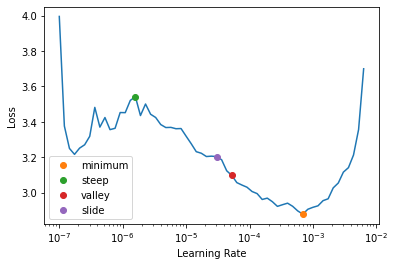

In [26]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [27]:
learn.fit_one_cycle(4, lr_max=5e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,2.247015,2.018291,0.323128,0.164427,0.254996,0.302695,0.899188,0.867089,0.882658,01:41
1,1.753040,2.032916,0.327237,0.166879,0.255898,0.308265,0.899868,0.867592,0.883259,00:55
2,1.209936,2.169424,0.319097,0.155819,0.244938,0.298304,0.898051,0.866345,0.881745,00:55
3,0.942856,2.310374,0.317550,0.154839,0.247913,0.297531,0.899090,0.865720,0.881923,00:55


Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/roberta-large/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/.cache/huggingface/transformers/tmp2xlpz28g


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/config.json in cache at /home/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
creating metadata file for /home/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
loading configuration file https://huggingface.co/roberta-large/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/vocab.json in cache at /home/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /home/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-large/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /home/.cache/huggingface/transformers/tmphhp8c0ua


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/merges.txt in cache at /home/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /home/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-large/resolve/main/vocab.json from cache at /home/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-large/resolve/main/merges.txt from cache at /home/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin in cache at /home/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
creating metadata file for /home/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
loading weights file https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin from cache at /home/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
All the weights of RobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.


In [28]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"(CNN) -- President Barack Obama and GOP vice presidential nominee Paul Ryan on Friday traded sharp criticism over health care reforms and Medicare, with each telling a leading advocacy group for senior citizens that the other was being untruthful. ""Contrary to what you've heard and what you may hear from subsequent speakers, Obamacare actually strengthened Medicare,"" the president told the AARP Liffe@50+ event, using the nickname for the 2010 Affordable Care Act that passed with no Republican s",NEW: Sen. Reid says Romney still isn't coming clean on taxes.\nPaul Ryan gets mixed reception at AARP event.\nRyan and President Obama accuse each other of being untruthful.\nObama says leadership means rejecting bad ideas.,"[ NEW: Paul Ryan says Obama's contention that health care law strengthened Medicare is ""just not true""\nObama and Ryan trade sharp, Almost the entire population of Oradour-sur-Glane, including 400 women and children, were gunned down or burned, Nathan Phillips was born healthy and fit to Laura Whitfield, 24, and her fiancé, Nathan Phillips, 34 .\n, Karen Glaser spent the night with Stephen - the first man she'd been intimate with since the break-up of her 15-year]"


In [29]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""

outputs = learn.blurr_generate(test_article, key="summary_texts", num_return_sequences=3)
outputs

[{'summary_texts': [' About 10 armed men raided a Swiss casino and made off with several hundred thousand Swiss francs .\nThe men split into two groups during the raid on the Grand Casino Basel .\nThere were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the robbers when he moved .',
   ' About 10 armed men raided a Swiss casino and made off with several hundred thousand Swiss francs .\nThe men split into two groups during the raid on the Grand Casino Basel .\nThere were no serious injuries, although one guest on the casino floor was kicked in the head by one of the robbers when he moved .',
   ' About 10 armed men raided a Swiss casino and made off with several hundred thousand Swiss francs .\nThe men split into two groups during the raid on the Grand Casino Basel .\nThere were no serious injuries, although one guest on the casino floor was kicked in the head by one of the robbers .']}]

In [30]:
cricket_over_12="""
Nehra to Mandeep, FOUR, first boundary for Mandeep and RCB. Full and on the pads, needed to be put away and Mandeep did just that, picked it up and dispatched it over mid-wicket, couple of bounces and into the fence",Nehra to Mandeep,FOUR.
Nehra to Mandeep, FOUR, back-to-back boundaries to end the first over. Again, Nehra is a tad short in his length, Mandeep had the width to cut and he didn't try to hit it hard, just placed it behind point and Bhuvi at third man gave up the chase pretty quickly",Nehra to Mandeep,FOUR.
Henriques to Kedar Jadhav, FOUR, hit straight back at Henriques and he was late to get his hand up. Once more the off-cutter which almost fooled Jadhav, who shimmied down and checked his drive, middled it alright to beat the mid-off fielder",Henriques to Kedar Jadhav,FOUR.
Nehra to Kedar Jadhav, FOUR, another full toss, it's Jadhav this time and he picks his spot into the deep mid-wicket fence. Not great bowling from Nehra. He's missing the yorker by quite a bit",Nehra to Kedar Jadhav,FOUR.
Nehra to Kedar Jadhav, FOUR, four more. Jadhav starting to really find his timing now and he's looking dangerous. This is smart batting rather than just throwing his bat at everything. He knows that fine leg is up and so he waits for the back of a length delivery to come to him before pulling it over the fielder. Nehra under pressure",Nehra to Kedar Jadhav,FOUR
Henriques to Kedar Jadhav, out Kedar Jadhav Run Out!! 1 run completed. Cutting has conjured a wicket out of nowhere. That's a sensational throw from the deep. My goodness. He's absolutely nailed the stump from long leg and Jadhav is out of here. This is a huge moment in the context of the match, especially as Jadhav was looking so good. Even this shot which he played was extraordinary. It was a length ball outside off, Jadhav sat on his back knee and scooped it over short fine leg. He was a little slow to decide on the second run, maybe a little hesitant and boy did Cutting make him pay! More than a couple of feet short, even with a dive. Kedar Jadhav run out (Cutting) 31(16) [4s-4 6s-1]",Henriques to Kedar Jadhav,OUT.
"""

outputs = learn.blurr_generate(cricket_over_12, key="summary_texts", num_return_sequences=3)
outputs

[{'summary_texts': [" Nehra bowled Mandeep short and short on the pads .\nMandeep missed the wicket by a short wicket but bowled it straight back .\nHenriques to Jadhav, FOUR, hit straight back at Henriques and he was late to get his hand up .\nJadhav then pulled it over the fielder's wicket over mid-wicket .\nCutting has conjured a wicket out of nowhere .",
   " Nehra bowled Mandeep short and short on the pads .\nMandeep missed the wicket by a short wicket but bowled it straight back .\nHenriques to Jadhav, FOUR, hit straight back at Henriques and he was late to get his hand up .\nJadhav then pulled it over the fielder's bowling line-up .\nCutting has conjured a wicket out of nowhere .",
   " Nehra bowled Mandeep short and short on the pads .\nMandeep missed the wicket by a short wicket but bowled it straight back .\nHenriques to Jadhav, FOUR, hit straight back at Henriques and he was late to get his hand up .\nJadhav then pulled it over the fielder's wicket .\nCutting has conjured a 

In [32]:
learn.metrics = None
learn.export(fname="model.pkl")